# Modelling

In this Notebook, we will build our recommendation system. As discussed in the Master Notebook, we are after both user recommendations and similar item recommendations.

In [34]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

from scipy import sparse

from lightfm import LightFM
from sklearn.metrics.pairwise import cosine_similarity
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

from scipy.spatial import distance

from sklearn.manifold import TSNE

import gensim.models.keyedvectors as gmk

import textwrap

from resources import *

#Import Warnings
import warnings

warnings.filterwarnings("ignore")

UsageError: Line magic function `%` not found.


We will run the following command as we update the `resources.py` file with useful helper functions. The magic command ensures the latest version is loaded into the Notebook.

In [2]:
%run resources.py

## Load data

We begin by loading the `recdata.csv` file, which specifically contains the user ids `uid` and game ids `id` owned.

In [3]:
# Load user items data
recdata = pd.read_csv('recdata.csv', index_col=0)
recdata = recdata.rename(columns={'variable': 'id', 'value': 'owned'})
recdata.head()

,uid,id,owned
0,0,10,1.0
1,1,10,1.0
2,3,10,1.0
3,4,10,1.0
4,10,10,1.0


We also load the `gamesdata.csv` file, which has the game names and details.

In [4]:
# Load games data
gamesdata = pd.read_csv('gamesdata.csv', index_col=0)
gamesdata.head()

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",4.49,http://steamcommunity.com/app/761140/reviews/?...,['Single-player'],4.99,False,761140.0,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive,NaN
2,彼岸领域,"['Action', 'Adventure', 'Casual']",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"['Action', 'Adventure', 'Casual']",0.83,http://steamcommunity.com/app/767400/reviews/?...,['Single-player'],0.99,False,767400.0,彼岸领域,NaN,NaN
3,NaN,NaN,Log Challenge,NaN,http://store.steampowered.com/app/773570/Log_C...,NaN,"['Action', 'Indie', 'Casual', 'Sports']",1.79,http://steamcommunity.com/app/773570/reviews/?...,"['Single-player', 'Full controller support', '...",2.99,False,773570.0,NaN,NaN,NaN
4,Trickjump Games Ltd,"['Action', 'Adventure', 'Simulation']",Battle Royale Trainer,Battle Royale Trainer,http://store.steampowered.com/app/772540/Battl...,2018-01-04,"['Action', 'Adventure', 'Simulation', 'FPS', '...",NaN,http://steamcommunity.com/app/772540/reviews/?...,"['Single-player', 'Steam Achievements']",3.99,False,772540.0,Trickjump Games Ltd,Mixed,NaN


## Additional Preprocessing

### Create interaction matrix

We will create an interactions matrix using the user-item data. This is done using the `create_interaction_matrix` function, which can be found in `resources.py`.

In [5]:
# Use create_interaction_matrix function
interactions = create_interaction_matrix(
    df=recdata, user_col="uid", item_col="id", rating_col="owned"
)
interactions.shape


(863, 4485)

From the shape, we note that we have 69277 unique users and 8791 different games represented.

In [6]:
# Preview head
interactions.head()

id,10,20,30,40,50,60,70,80,130,220,...,513440,513930,517790,517810,517910,521200,521340,521570,523760,527810
uid,,,,,,,,,,,,,,,,,,,,,
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Train test split

We will manually split the interactions matrix into a training set and test set for evaluation purposes.

In [7]:
# Get number of users
len(interactions)

863

We choose to have roughly 80% of our data as training and 20% as test.

In [8]:
# Establish number of users in train/test sets

train_num = round((80 / 100) * len(interactions), 0)
print(f'We desire {train_num} users in our training set.')

test_num = len(interactions) - train_num
print(f'We desire {test_num} users in our test set.')

We desire 690.0 users in our training set.
We desire 173.0 users in our test set.


In [9]:
# Define train and test sets
train = interactions[:690]
test = interactions[173:]

### Create user dictionary

We will create a dictionary which matches users with another a counter `id`, by using the `create_user_dict` function, which can be found in `resources.py`.

In [10]:
# Create user dictionary using helper function
user_dict = create_user_dict(interactions=interactions)

### Create item dictionary

We will create a dictionary which matches each game `id` with its `title`, by using the `create_item_dict`function, which can be found in `resources.py`.

In [11]:
# Create game dictionary using helper function
games_dict = create_item_dict(df=gamesdata, id_col='id', name_col='title')

### Create sparse matrices

We will transform the interaction into a sparse matrix, to make computations efficient.

For the trainset, we simply use the `sparse.csr_matrix()` function.

With the test set, due to a known issue, we need to add additional rows so that the number of rows matches the trains set.

In [12]:
# Create sparse matrices for evaluation
train_sparse = sparse.csr_matrix(train.values)

# Add X users to Test so that the number of rows in Train match Test
N = train.shape[0]                  # Rows in Train set
n, m = test.shape                   # Rows & columns in Test set
z = np.zeros([(N - n), m])          # Create the necessary rows of zeros with m columns

# test = test.toarray() #Temporarily convert Test into a numpy array

test = np.vstack((test, z))             # Vertically stack Test on top of the blank users
test_sparse = sparse.csr_matrix(test)   # Convert back to sparse


## Modelling using LightFM

To build our recommendation engine, we will make use of the LightFM library.

### WARP loss model

For the first model, we will choose the loss function to be WARP.

In [13]:
# Instantiate and fit model
mf_model_warp = run_model(
    interactions=train, n_components=30, loss="warp", epoch=30, n_jobs=4
)


In [14]:
# Get precision
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

train_precision = precision_at_k(mf_model_warp, train_sparse, k=10).mean()
test_precision = precision_at_k(mf_model_warp, test_sparse, k=10).mean()
print("Precision: train %.2f, test %.2f." % (train_precision, test_precision))


Precision: train 0.72, test 0.43.


We note that the precision score for the test is low, but this is expected due to the sheer volume of games available and the scarcity of interactions.

In [15]:
# Get AUC
train_auc = auc_score(mf_model_warp, train_sparse).mean()
test_auc = auc_score(mf_model_warp, test_sparse).mean()
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

AUC: train 0.98, test 0.87.


The AUC score is very high, which is great.

### BPR loss model

We will compare the model above with a model using BPR as the loss function.

In [16]:
# Instantiate and fit model
mf_model_bpr = run_model(interactions=train,
                         n_components=30,
                         loss='bpr',
                         epoch=30,
                         n_jobs=4)

In [17]:
# Get precision
train_precision = precision_at_k(mf_model_bpr, train_sparse, k=10).mean()
test_precision = precision_at_k(mf_model_bpr, test_sparse, k=10).mean()
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

Precision: train 0.76, test 0.37.


Again, we note that the precision score for the test is low, but this is expected due to the sheer volume of games available and the scarcity of interactions.

In [18]:
# Get AUC
train_auc = auc_score(mf_model_bpr, train_sparse).mean()
test_auc = auc_score(mf_model_bpr, test_sparse).mean()
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

AUC: train 0.95, test 0.66.


Again, the AUC score is good, though significantly lower for the test set compare to the train set.

Based on these two models, we will keep WARP as the loss function due to better performance all round.

### Adjust num of components

The `n_components` parameter controlls the number of embeddings (dimension of the features in the latent space.)

We will vary this number, lowering it to `10` first and then increasing it to `50` to see how this affects model performance.

In [19]:
# Instantiate and fit model
mf_model_warp_2 = run_model(interactions=train,
                            n_components=10,
                            loss='warp',
                            epoch=30,
                            n_jobs=4)

In [20]:
# Get precision
train_precision = precision_at_k(mf_model_warp_2, train_sparse, k=10).mean()
test_precision = precision_at_k(mf_model_warp_2, test_sparse, k=10).mean()
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

Precision: train 0.65, test 0.50.


In [21]:
# Get AUC
train_auc = auc_score(mf_model_warp_2, train_sparse).mean()
test_auc = auc_score(mf_model_warp_2, test_sparse).mean()
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

AUC: train 0.96, test 0.89.


In [22]:
# Instantiate and fit model
mf_model_warp_50 = run_model(interactions=train,
                             n_components=50,
                             loss='warp',
                             epoch=30,
                             n_jobs=4)

In [23]:
# Get precision
train_precision = precision_at_k(mf_model_warp_50, train_sparse, k=10).mean()
test_precision = precision_at_k(mf_model_warp_50, test_sparse, k=10).mean()
print('Precision: train %.2f, test %.2f.' % (train_precision, test_precision))

Precision: train 0.75, test 0.42.


In [24]:
# Get AUC
train_auc = auc_score(mf_model_warp_50, train_sparse).mean()
test_auc = auc_score(mf_model_warp_50, test_sparse).mean()
print('AUC: train %.2f, test %.2f.' % (train_auc, test_auc))

AUC: train 0.99, test 0.87.


Overall, we see that varying the `n_components` feature has little impact on overall model performance.

### Final model

We train the chosen model (WARP loss and 30 components) on the full interactions matrix.

In [25]:
# Instantiate and fit model on full interactions set
mf_model = run_model(interactions=interactions,
                     n_components=30,
                     loss='warp',
                     epoch=30,
                     n_jobs=4)

## Embeddings

Before using our model to provide recommendations, let us explore the embedding space.

### Retrieve embeddings matrix

In [26]:
# Get embeddings
embeddings = mf_model.item_embeddings
embeddings

array([[-0.43567038,  0.7474791 , -0.18764488, ...,  0.4241086 ,
         0.22136402,  0.48393118],
       [-0.06051169,  0.29036492,  0.0956243 , ...,  0.06189163,
        -0.621129  ,  0.559598  ],
       [-0.38365045,  0.38450596, -0.09836718, ...,  0.14109302,
        -0.29027724,  0.4983573 ],
       ...,
       [-0.16464418,  0.11439788,  0.26920748, ...,  0.01456223,
         0.4816941 ,  0.07963528],
       [-0.21888757, -0.06979045, -0.00391839, ...,  0.00237   ,
         0.30842113,  0.00872333],
       [ 0.14889975, -0.46212628,  0.1252786 , ..., -0.39204314,
         0.29626498, -0.33397523]], dtype=float32)

In [27]:
# View shape
embeddings.shape

(4485, 30)

Our embeddings array has 8791 rows, with each row representing a game. Each row has 30 numbers, representing the components of our game embeddings. This is because we set `n_components` to be 30 in our model.

Let's investigate a sample game vector.

In [28]:
embeddings[0]

array([-0.43567038,  0.7474791 , -0.18764488,  0.19131546,  0.47647545,
       -0.4378438 , -0.03912763,  0.20134117, -0.3508965 , -0.01933642,
       -0.11270157,  0.87302816, -0.41694188, -0.15922137,  0.11412053,
        0.0903699 , -0.30220872, -0.29104114, -0.68500906, -0.2012403 ,
        0.26137635, -0.03674191, -0.11310232, -1.3489708 , -0.5617479 ,
       -0.13467579,  0.5257406 ,  0.4241086 ,  0.22136402,  0.48393118],
      dtype=float32)

To retrieve the name of the game, we first look up the game id using our interactions matrix and then obtain the name using the games dictionary.

In [29]:
firstgameid = interactions.columns[0]
games_dict[firstgameid]

'Counter-Strike'

### Pair similarity

Let us examine how close or distant pairs of games are in the embedding space. The embedding space can be interpreted as a distance metric and so we would expect similar games to have similar vectors.

Our first game will be `Counter-Strike` as seen above. 

We would expect it to be similar to `Left 4 Dead 2`.

In [30]:
# Get data for both games
gamesdata[(gamesdata['title'] == 'Counter-Strike') | (gamesdata['title'] == 'Left 4 Dead 2')]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
31528,Valve,['Action'],Left 4 Dead 2,Left 4 Dead 2,http://store.steampowered.com/app/550/Left_4_D...,2009-11-16,"['Zombies', 'Co-op', 'FPS', 'Multiplayer', 'Ac...",NaN,http://steamcommunity.com/app/550/reviews/?bro...,"['Single-player', 'Multi-player', 'Co-op', 'St...",19.99,False,550.0,Valve,Overwhelmingly Positive,89.0
32105,Valve,['Action'],Counter-Strike,Counter-Strike,http://store.steampowered.com/app/10/CounterSt...,2000-11-01,"['Action', 'FPS', 'Multiplayer', 'Shooter', 'C...",NaN,http://steamcommunity.com/app/10/reviews/?brow...,"['Multi-player', 'Valve Anti-Cheat enabled']",9.99,False,10.0,Valve,Overwhelmingly Positive,88.0


Let us look at the vectors for these two games.

In [31]:
# Set index for Counter-Strike
cs_index = 0

# Obtain embeddings vector 
cs_vector = embeddings[cs_index]

cs_vector

array([-0.43567038,  0.7474791 , -0.18764488,  0.19131546,  0.47647545,
       -0.4378438 , -0.03912763,  0.20134117, -0.3508965 , -0.01933642,
       -0.11270157,  0.87302816, -0.41694188, -0.15922137,  0.11412053,
        0.0903699 , -0.30220872, -0.29104114, -0.68500906, -0.2012403 ,
        0.26137635, -0.03674191, -0.11310232, -1.3489708 , -0.5617479 ,
       -0.13467579,  0.5257406 ,  0.4241086 ,  0.22136402,  0.48393118],
      dtype=float32)

In [32]:
# Retrieve game id for LFD2
lfd2_id = gamesdata[gamesdata['title'] == 'Left 4 Dead 2']['id'].values[0]

# Obtain index for Squad in interactions matrix
lfd2_index = list(interactions.columns).index(lfd2_id)

# Obtain embeddings vector
lfd2_vector = embeddings[lfd2_index]

lfd2_vector

array([-0.47042826,  0.8219506 ,  0.03357815,  0.7584672 ,  0.31673527,
       -0.60650617, -0.23307864, -0.15779261, -0.56038797, -0.18457173,
        0.17127481,  0.49731478, -0.49272856, -0.46795732,  0.27400774,
        0.084766  , -0.5935525 ,  0.4868253 ,  0.3601738 , -0.72380084,
        0.41657546, -0.13003275,  0.02252604, -0.23085302, -0.65220535,
       -0.4745413 ,  0.7337816 ,  0.34152186, -0.52458864,  0.4143889 ],
      dtype=float32)

To assign a single value to the similarity between these two vectors, we calculate the distance between them. Let us first compute the Euclidean distance.

In [36]:
# Compute Euclidean distance
from scipy.spatial import distance

distance.euclidean(cs_vector, lfd2_vector)


2.2604076862335205

Let us compare this figure with a pair of games we believe to be very different.

In [37]:
# Get data for both games
gamesdata[(gamesdata['title'] == 'Counter-Strike') | (gamesdata['title'] == 'The Room')]

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
2471,Fireproof Games,"['Adventure', 'Indie']",The Room,The Room,http://store.steampowered.com/app/288160/The_R...,2014-07-28,"['Puzzle', 'Adventure', 'Point & Click', 'Indi...",NaN,http://steamcommunity.com/app/288160/reviews/?...,"['Single-player', 'Steam Achievements', 'Steam...",4.99,False,288160.0,Fireproof Games,Overwhelmingly Positive,73.0
32105,Valve,['Action'],Counter-Strike,Counter-Strike,http://store.steampowered.com/app/10/CounterSt...,2000-11-01,"['Action', 'FPS', 'Multiplayer', 'Shooter', 'C...",NaN,http://steamcommunity.com/app/10/reviews/?brow...,"['Multi-player', 'Valve Anti-Cheat enabled']",9.99,False,10.0,Valve,Overwhelmingly Positive,88.0


In [38]:
# Retrieve game id for The Room
room_id = gamesdata[gamesdata['title'] == 'The Room']['id'].values[0]

# Obtain index for Squad in interactions matrix
room_index = list(interactions.columns).index(room_id)

# Obtain embeddings vector
room_vector = embeddings[room_index]

room_vector

array([-0.17378594, -0.2542941 ,  0.05175954,  0.27832255,  0.12795031,
       -0.13697146, -0.03977821,  0.28319085, -0.13932626, -0.20091075,
        0.61267924,  0.1704946 , -0.1138439 ,  0.19521815, -0.03857845,
        0.09686796, -0.1404017 ,  0.02123421, -0.28638276, -0.01775335,
       -0.3957468 , -0.1038993 , -0.01922617,  0.28721458,  0.46438047,
       -0.03024181,  0.22736427,  0.31336486,  0.01695248, -0.2034162 ],
      dtype=float32)

In [39]:
# Compute Euclidean distance
distance.euclidean(cs_vector, room_vector)

2.794977903366089

When looking at the similarity of embeddings, it is more common to look at cosine similarity. Cosine similarity ranges between -1 and 1 based on the angle between the vectors. From this figure, cosine distance is defined as 1 minus the cosine similarity and therefore a value between 0 and 2.

In [40]:
print(f'Cosine distance between Counter Strike and Left 4 Dead 2: {distance.cosine(cs_vector, lfd2_vector)}')
print(f'Cosine distance between Counter Strike and The Room: {distance.cosine(cs_vector, room_vector)}')

Cosine distance between Counter Strike and Left 4 Dead 2: 0.40881842374801636
Cosine distance between Counter Strike and The Room: 1.0277834814041853


### Exploring embeddings with Gensim

In [47]:

from gensim.models.keyedvectors import Word2VecKeyedVectors
embedding_size = embeddings.shape[1]

# Create instance
# kv = WordEmbeddingsKeyedVectors(embedding_size)
kv = gmk.KeyedVectors(embedding_size)

# Get list of game names in correct order to match embeddings
gameslist = []
for game_id in interactions.columns:
    name = games_dict[game_id]
    gameslist.append(name)

# Add to kv
kv.add_vectors(gameslist, embeddings)

Let us obtain the games closest to `Counter-Strike`.

In [48]:
# Get games closest to Counter-Strike
kv.most_similar('Counter-Strike')

[('Counter-Strike: Condition Zero', 0.9593813419342041),
 ('Ricochet', 0.7716584801673889),
 ('Deathmatch Classic', 0.7612374424934387),
 ('Counter-Strike: Source', 0.7594258785247803),
 ('Day of Defeat', 0.7554303407669067),
 ('Left 4 Dead', 0.6918867826461792),
 ('Half-Life: Source', 0.6867163777351379),
 ('Half-Life Deathmatch: Source', 0.6851688027381897),
 ('Half-Life 2', 0.6754992008209229),
 ('Poker Night at the Inventory', 0.6513427495956421)]

In [49]:
# Get games closest to Left 4 Dead 2
kv.most_similar('Left 4 Dead 2')

[('Counter-Strike: Global Offensive', 0.928499162197113),
 ('Terraria', 0.8801946043968201),
 ('Borderlands 2', 0.8787333369255066),
 ("Garry's Mod", 0.8746289610862732),
 ('Counter-Strike: Source', 0.874309241771698),
 ('Chivalry: Medieval Warfare', 0.8666425347328186),
 ('Killing Floor', 0.8545166850090027),
 ('Portal 2', 0.8532670736312866),
 ('Saints Row: The Third', 0.8519155979156494),
 ('Defence Alliance 2', 0.8448004126548767)]

In [50]:
# Get games closest to The Room
kv.most_similar('The Room')

[('Duck Game', 0.5960033535957336),
 ('Hacker Evolution Duality', 0.5895370244979858),
 ('Hacknet', 0.5888202786445618),
 ('Earth 2150 Trilogy', 0.5672165751457214),
 ('CAT Interstellar', 0.5640320181846619),
 ('Chains', 0.5624843239784241),
 ('Gun Rocket', 0.5574231147766113),
 ('Bad Bots', 0.5535194277763367),
 ('Collisions', 0.5438698530197144),
 ("Disney•Pixar Cars Toon: Mater's Tall Tales", 0.5228424072265625)]

In [51]:
# Get games closest to RollerCoaster Tycoon
kv.most_similar('RollerCoaster Tycoon®: Deluxe')

[('DisplayFusion', 0.623913049697876),
 ('Bejeweled® 3', 0.5976985096931458),
 ('Roguelands', 0.5829875469207764),
 ('Feeding Frenzy 2 Deluxe', 0.576656699180603),
 ('Rock of Ages', 0.574921190738678),
 ('RollerCoaster Tycoon® 2: Triple Thrill Pack', 0.5669092535972595),
 ('Waveform', 0.5488443970680237),
 ('Boson X', 0.5313336253166199),
 ('Pixel Piracy', 0.5284640789031982),
 ('BattleBlock Theater®', 0.5231937766075134)]

In [52]:
# Get games closest to Dishonored
kv.most_similar('Dishonored')

[('Borderlands 2', 0.8774726986885071),
 ('The Witcher 2: Assassins of Kings Enhanced Edition', 0.8479509353637695),
 ('Portal 2', 0.824769139289856),
 ('BioShock Infinite', 0.8239922523498535),
 ('Fallout: New Vegas', 0.8217219710350037),
 ('Tomb Raider', 0.8210669159889221),
 ('Middle-earth™: Shadow of Mordor™', 0.807460606098175),
 ('Crysis', 0.791682779788971),
 ('Metro 2033 Redux', 0.7804405093193054),
 ('Just Cause 2', 0.7801697850227356)]

In [53]:
# Get games closest to The Jackbox Party Pack
kv.most_similar('The Jackbox Party Pack')

[('Beyond Divinity', 0.6602115035057068),
 ('Out There: Ω Edition', 0.6108164191246033),
 ('Divine Divinity', 0.6004356145858765),
 ('Prince of Persia®: The Sands of Time', 0.5619730949401855),
 ('Westerado: Double Barreled', 0.5613027215003967),
 ('Prince of Persia: The Forgotten Sands™', 0.5539504885673523),
 ('MirrorMoon EP', 0.5482065677642822),
 ('Galactic Civilizations III', 0.5462910532951355),
 ('The Banner Saga', 0.5455055236816406),
 ('Warhammer® 40,000: Dawn of War® - Dark Crusade', 0.5369604825973511)]

In [54]:
# Get games closest to American Truck Simulator
kv.most_similar('American Truck Simulator')

[('ESEA', 0.7413171529769897),
 ('Squad', 0.710640549659729),
 ('BeamNG.drive', 0.6956651210784912),
 ('GT Power Pack – Expansion Pack for RACE 07', 0.6892653703689575),
 ('STCC The Game 2 – Expansion Pack for RACE 07', 0.6857785582542419),
 ('Arma 2', 0.684453547000885),
 ("Tom Clancy's Rainbow Six® Siege", 0.6789617538452148),
 ('theHunter: Primal', 0.6739115715026855),
 ('Arma 3', 0.6735358834266663),
 ('Next Car Game: Wreckfest', 0.6554087996482849)]

In [60]:
# Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

from scipy import sparse

from lightfm import LightFM
from sklearn.metrics.pairwise import cosine_similarity
from lightfm.evaluation import precision_at_k
from lightfm.evaluation import auc_score

from scipy.spatial import distance

from sklearn.manifold import TSNE

import gensim.models.keyedvectors as gmk
import textwrap
from resources import *

#Import Warnings
import warnings

warnings.filterwarnings("ignore")

UsageError: Line magic function `%` not found.


In [61]:

def plot_similar(item, ax, topn=5):
    '''
    Plots a bar chart of similar items
    Arguments:
        - item, string
        - ax, axes on which to plot
        - topn (default = 5) number of similar items to plot
    '''
    sim = kv.most_similar(item, topn=topn)[::-1]
    y = np.arange(len(sim))
    w = [t[1] for t in sim]
    ax.barh(y, w)
    left = min(.6, min(w))
    ax.set_xlim(right=1.0, left=left)
    # Split long titles over multiple lines
    labels = [textwrap.fill(t[0], width=24)
              for t in sim]
    ax.set_yticks(y)
    ax.set_yticklabels(labels)
    ax.set_title(item)

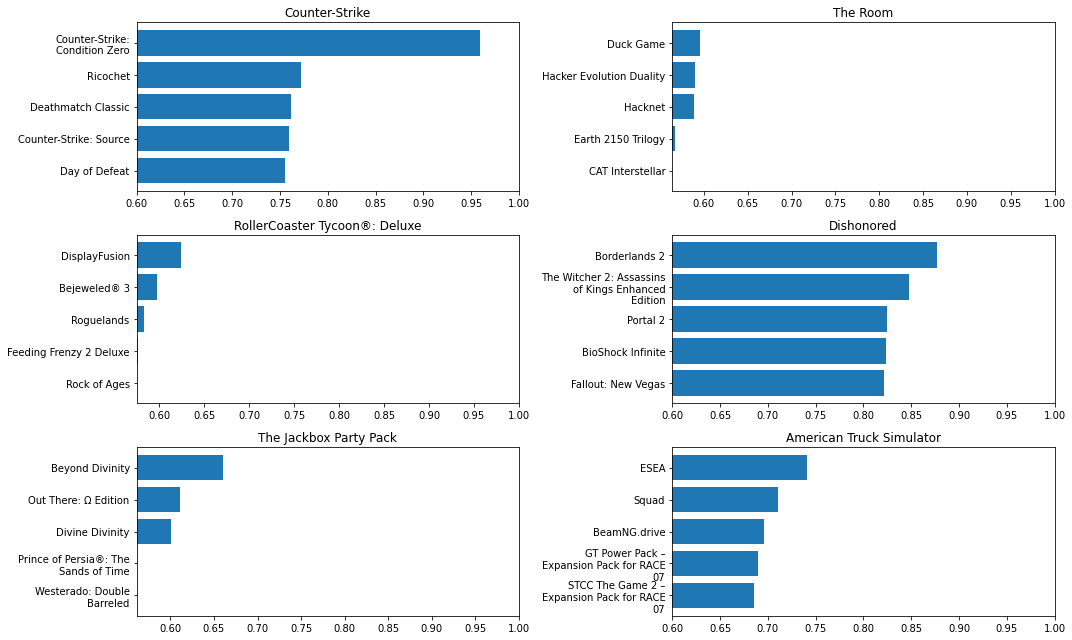

In [62]:
# Define list of games to visualise similar items for
games = ['Counter-Strike', 'The Room', 'RollerCoaster Tycoon®: Deluxe', 'Dishonored',
         'The Jackbox Party Pack', 'American Truck Simulator']

# Set figure/axes to have 3 rows with 2 columns
fig, axes = plt.subplots(3, 2, figsize=(15, 9))

# Loop through games and use plot_similar function 
for game, ax in zip(games, axes.flatten()):
    plot_similar(game, ax)

fig.tight_layout()

### Visualizing embeddings with t-SNE

We will use the t-SNE algorithm to visualise embeddings, going from a 30-dimensional space (number of components) to a 2-dimensional space.

In [65]:
from sklearn.manifold import TSNE

# Instantialte tsne, specify cosine metric
tsne = TSNE(random_state=0, n_iter=1000, metric="cosine")

# Fit and transform
embeddings2d = tsne.fit_transform(embeddings)


/home/besmaks/.config/JetBrains/DataSpell2022.1/projects/workspace/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/besmaks/.config/JetBrains/DataSpell2022.1/projects/workspace/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/besmaks/.config/JetBrains/DataSpell2022.1/projects/workspace/venv/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


Let's create a DataFrame with the game name and 2d embeddings.

In [66]:
# Create DF
embeddingsdf = pd.DataFrame()

# Add game names
embeddingsdf['game'] = gameslist

# Add x coordinate
embeddingsdf['x'] = embeddings2d[:, 0]

# Add y coordinate
embeddingsdf['y'] = embeddings2d[:, 1]

# Check
embeddingsdf.head()

,game,x,y
0,Counter-Strike,-47.136780,45.493423
1,Team Fortress Classic,-44.785858,47.552334
2,Day of Defeat,-46.911488,46.855701
3,Deathmatch Classic,-46.951382,46.864124
4,Half-Life: Opposing Force,-44.844685,47.541260


Let's draw a scatterplot of our games, using the 2D mapping we created.

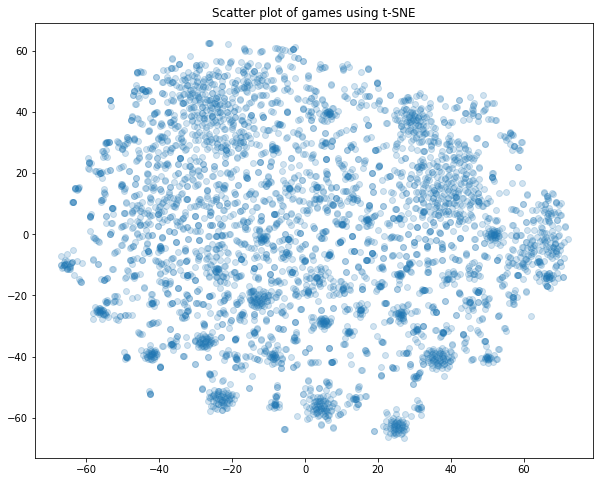

In [73]:
# Set figsize
fig, ax = plt.subplots(figsize=(10, 8))

# Scatter points, set alpha low to make points translucent
ax.scatter(embeddingsdf.x, embeddingsdf.y, alpha=.2)

plt.title('Scatter plot of games using t-SNE')

plt.show()

It is hard to judge anything by the shape of the plot alone. However as a check, let us ensure that games we expect to be close are indeed close in this 2-dimensional space.

Let's leave `Counter-Strike` alone and look for the `Roller Coaster Tycoon` games.

In [68]:
match = embeddingsdf[embeddingsdf.game.str.contains('RollerCoaster')]
match

,game,x,y
69,RollerCoaster Tycoon® 3: Platinum,-11.448170,34.549210
2356,RollerCoaster Tycoon®: Deluxe,-24.892012,22.361584
2357,RollerCoaster Tycoon® 2: Triple Thrill Pack,14.608994,-49.854618


We will highlight the above games on our scatter plot.

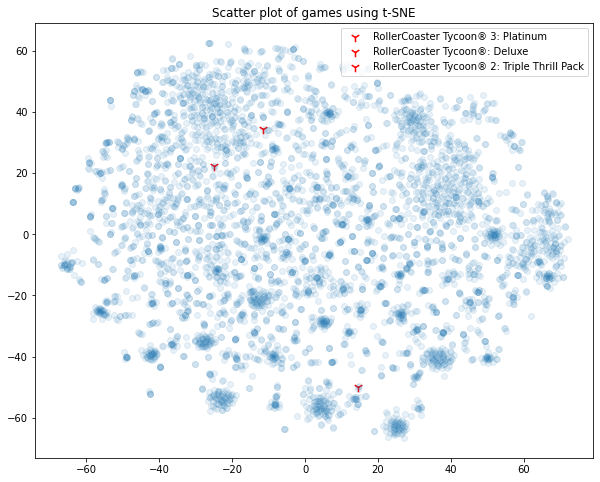

In [69]:
# Set figsize
fig, ax = plt.subplots(figsize=(10, 8))

Xlabeled = embeddings2d[match.index, 0]
Ylabeled = embeddings2d[match.index, 1]
labels = match['game'].values

# Scatter specific points
for x, y, label in zip(Xlabeled, Ylabeled, labels):
    ax.scatter(x, y, marker='1', label=label, s=90, color='red')

# Scatter points, set alpha low to make points translucent
ax.scatter(embeddingsdf.x, embeddingsdf.y, alpha=.1)

plt.title('Scatter plot of games using t-SNE')
plt.legend()

plt.show()

## User Recommendations

### Recommendations for existing user

In [80]:
# Get recommendations
# user_dict


In [81]:
rec_list_u12 = get_recs(
    model=mf_model,
    interactions=interactions,
    user_id=2,
    user_dict=user_dict,
    item_dict=games_dict,
    threshold=0,
    num_items=5,
    show_known=True,
    show_recs=True,
)


Known Likes:
1- Idling to Rule the Gods
2- Blueprint Tycoon
3- Factorio
4- Endless Sky
5- Gridworld
6- Undertale
7- Oxenfree
8- Empyrion - Galactic Survival
9- Fallout 4
10- Astro Lords: Oort Cloud
11- TIS-100
12- Hacknet
13- Transmissions: Element 120
14- Total War: WARHAMMER
15- Quiplash
16- Besiege
17- Big Pharma
18- Armed with Wings: Rearmed
19- Deus Ex: Mankind Divided
20- Rise to Ruins
21- VoidExpanse
22- Don't Starve Together
23- Life is Strange - Episode 1
24- Fractured Space
25- The Desolate Hope
26- Starship Corporation
27- RollerCoaster Tycoon®: Deluxe
28- SOMA
29- Creeper World 3: Arc Eternal
30- No Man's Sky
31- Space Run
32- XCOM® 2
33- Ether One
34- 3089 -- Futuristic Action RPG
35- EDEN STAR
36- The Talos Principle
37- FortressCraft Evolved!
38- Lovers in a Dangerous Spacetime
39- Risk of Rain
40- Craft The World
41- Crypt of the NecroDancer
42- Democracy 3
43- Rogue Legacy
44- Spelunky
45- Magicka 2
46- Edge of Space
47- Transistor
48- Mad Max
49- Surgeon Simulator
50-

These look reasonable, for instance we note the choice of sequels e.g. Portal 2 when user owns Portal.

## Item Recommendations

### Create item embedding matrix

In [82]:
item_dist = create_item_emdedding_matrix(model=mf_model, interactions=interactions)

In [83]:
item_dist.shape

(4485, 4485)

In [84]:
item_dist.head()

id,10,20,30,40,50,60,70,80,130,220,...,513440,513930,517790,517810,517910,521200,521340,521570,523760,527810
id,,,,,,,,,,,,,,,,,,,,,
10,1.000000,0.604981,0.755430,0.761237,0.578081,0.771659,0.560780,0.959381,0.590726,0.675499,...,-0.412075,-0.336834,-0.358604,-0.249281,-0.259612,-0.351994,-0.256405,-0.331423,-0.188529,-0.329041
20,0.604981,1.000000,0.666289,0.674976,0.972084,0.667349,0.929328,0.542390,0.970696,0.794972,...,-0.497318,-0.259144,-0.147662,-0.125282,-0.393444,-0.323050,-0.125726,-0.447419,-0.101628,-0.303885
30,0.755430,0.666289,1.000000,0.980157,0.686640,0.974242,0.594259,0.682710,0.689575,0.495973,...,-0.137809,-0.004759,-0.097289,0.021266,-0.208805,-0.177530,-0.098483,-0.314411,-0.248977,0.010820
40,0.761237,0.674976,0.980157,1.000000,0.708791,0.990619,0.591127,0.683286,0.710807,0.496736,...,-0.132857,0.019184,-0.039040,0.075153,-0.207010,-0.170494,-0.061075,-0.316765,-0.191405,0.035479
50,0.578081,0.972084,0.686640,0.708791,1.000000,0.697154,0.909425,0.503319,0.992596,0.746335,...,-0.459506,-0.202732,-0.103486,-0.088407,-0.378809,-0.252138,-0.120580,-0.457637,-0.047456,-0.228439


### Generate item recommendations

In [85]:
# Similar items to item_id 10 - Counter Strike
item_rec_list_10 = get_item_recs(item_emdedding_matrix=item_dist,
                                 item_id=10,
                                 item_dict=games_dict,
                                 n_items=5,
                                 show=True)

Item of interest: Counter-Strike
Similar items:
1- Counter-Strike: Condition Zero
2- Ricochet
3- Deathmatch Classic
4- Counter-Strike: Source
5- Day of Defeat


In [86]:
gamesdata[gamesdata['title'] == 'The Witness']

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
5210,"Thekla, Inc.","['Adventure', 'Indie']",The Witness,The Witness,http://store.steampowered.com/app/210970/The_W...,2016-01-26,"['Puzzle', 'Exploration', 'First-Person', 'Sin...",NaN,http://steamcommunity.com/app/210970/reviews/?...,"['Single-player', 'Steam Achievements', 'Capti...",39.99,False,210970.0,"Thekla, Inc.",Very Positive,87.0


In [87]:
# Similar items to item_id 210970 The Witness
item_rec_list_210970 = get_item_recs(item_emdedding_matrix=item_dist,
                                     item_id=210970,
                                     item_dict=games_dict,
                                     n_items=5,
                                     show=True)

Item of interest: The Witness
Similar items:
1- Grim Legends 2: Song of the Dark Swan
2- Shardlight
3- Detective Grimoire
4- Until I Have You
5- Blackwell Deception


In [88]:
gamesdata[gamesdata['title'] == 'American Truck Simulator']

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
24194,SCS Software,"['Indie', 'Simulation']",American Truck Simulator,American Truck Simulator,http://store.steampowered.com/app/270880/Ameri...,2016-02-02,"['Simulation', 'Driving', 'Open World', 'Ameri...",NaN,http://steamcommunity.com/app/270880/reviews/?...,"['Single-player', 'Steam Achievements', 'Steam...",19.99,False,270880.0,SCS Software,Very Positive,76.0


In [89]:
# Similar items to item_id 270880 American Truck Simulator
item_rec_list_270880 = get_item_recs(item_emdedding_matrix=item_dist,
                                     item_id=270880,
                                     item_dict=games_dict,
                                     n_items=5,
                                     show=True)

Item of interest: American Truck Simulator
Similar items:
1- ESEA
2- Squad
3- BeamNG.drive
4- GT Power Pack – Expansion Pack for RACE 07
5- STCC The Game 2 – Expansion Pack for RACE 07


These look reasonable.

## Recommendations for new user - Demo

Example games owned:
* 210970 The Witness
* 288160 The Room
* 550 Left 4 Dead 2

In [90]:
# Get list of owned games from user

# Create empty list to store game ids
ownedgames = []

# Create loop to prompt for game id and ask if want to continue
moretoadd = 'y'
while moretoadd == 'y':
    game = input('Please enter the game id: ')
    ownedgames.append(game)
    moretoadd = input('Do you have more games to add? y/n ')

# Print list of owned games
print(f"You own the following games: {ownedgames}")

You own the following games: ['Half-Life']
